In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from kuma_utils.stats import PropensityScoreMatching, make_demographic_table, love_plot
from kuma_utils.preprocessing import PrepPipeline, SelectCategorical, SelectNumerical, DummyVarible, DistTransformer, Cast

In [3]:
# from catboost.datasets import adult
# train, test = adult()
train = pd.read_csv('input/uci_train.csv')
test = pd.read_csv('input/uci_test.csv')
full_dataset = pd.concat([train.assign(group='train'), test.assign(group='test')], axis=0)

# Make demopgraphic table (a.k.a. Table 1)
for numeric variables:
- run KS test
    - if the varible follows normal distribution, run T test
    - if no, run Mann Whitney U test
    
for categorical variables:
- run chi-squared test

In [4]:
full_dataset = full_dataset[
    ['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss', 'group']].copy().sample(10000).reset_index()  # To make it simple

In [5]:
make_demographic_table(
    full_dataset, 
    group_col='group', display_cols=full_dataset.columns, categorical_omission_count=10)

,_item,_type,_ks_stat,_stat_test,_nan_info,train,test,p-value
0,N,numerical,NaN,None,False,6699,3301,None
1,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,848 (12.7%),452 (13.7%),0.157
2,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,867 (12.9%),399 (12.1%),0.239
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,835 (12.5%),385 (11.7%),0.263
4,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,751 (11.2%),368 (11.1%),0.953
5,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,743 (11.1%),372 (11.3%),0.816
6,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,702 (10.5%),331 (10.0%),0.507
7,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,570 (8.5%),294 (8.9%),0.530
8,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,401 (6.0%),201 (6.1%),0.874
9,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,394 (5.9%),195 (5.9%),0.995


# Propensity score matching
Matching methods
- Greedy: very slow
- Hungarian algorithm: very fast :)

In [6]:
psm_greedy = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'], 
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='greedy')
make_demographic_table(
    psm_greedy.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5) #  ~60s

Logger created at 24/10/24:05:27:44
eval_metric automatically selected.
05:27:44 [None]	best score is 0.528469


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3298,3298,None
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1322 (40.1%),1331 (40.4%),0.841
2,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,452 (13.7%),435 (13.2%),0.564
3,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,399 (12.1%),421 (12.8%),0.433
4,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,385 (11.7%),364 (11.0%),0.438
5,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,372 (11.3%),377 (11.4%),0.877
6,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,368 (11.2%),370 (11.2%),0.969
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,1059 (32.1%),1068 (32.4%),0.833
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,741 (22.5%),733 (22.2%),0.836
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,626 (19.0%),613 (18.6%),0.705


In [7]:
psm_fast = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='hungarian')
make_demographic_table(
    psm_fast.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5)  # ~0.5s

Logger created at 24/10/24:05:28:40
eval_metric automatically selected.
05:28:40 [None]	best score is 0.528469


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3298,3298,None
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1322 (40.1%),1336 (40.5%),0.744
2,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,452 (13.7%),439 (13.3%),0.666
3,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,399 (12.1%),423 (12.8%),0.391
4,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,385 (11.7%),362 (11.0%),0.393
5,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,372 (11.3%),374 (11.3%),0.969
6,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,368 (11.2%),364 (11.0%),0.906
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,1059 (32.1%),1067 (32.4%),0.854
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,741 (22.5%),736 (22.3%),0.906
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,626 (19.0%),612 (18.6%),0.682


# Feature importances for PSM model


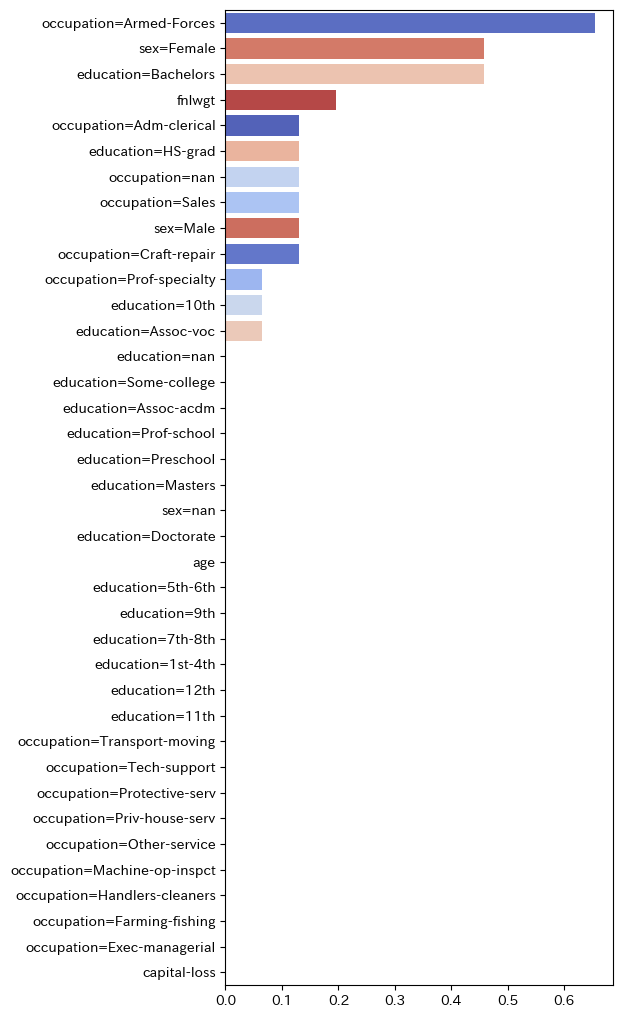

In [8]:
psm_fast.plot_feature_importance(full_dataset)

# PSM with GBDT
cross validation is supported!

In [9]:
psm_lgb = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), OrdinalEncoder()]),
    numerical_encoder=PrepPipeline([SelectNumerical()]),
    model=LGBMClassifier,
    trainer_params={
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': 0,
        },
        'fit_params': {
            'num_boost_round': 500,
            'callbacks': [lgb.early_stopping(stopping_rounds=50, verbose=True), lgb.log_evaluation(25)]
        }
    },
    fit_method='cv',
    matching_method='hungarian')
make_demographic_table(psm_lgb.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5)  # ~10s

Logger created at 24/10/24:05:28:41
Training until validation scores don't improve for 50 rounds
[25]	cv_agg's valid auc: 0.495588 + 0.00932999
[50]	cv_agg's valid auc: 0.492274 + 0.00802908
Early stopping, best iteration is:
[2]	cv_agg's valid auc: 0.501437 + 0.00912839
05:28:43 [2]	best score is 0.501437


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3127,3127,None
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1253 (40.1%),1218 (39.0%),0.379
2,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,422 (13.5%),412 (13.2%),0.738
3,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,389 (12.4%),397 (12.7%),0.789
4,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,363 (11.6%),376 (12.0%),0.638
5,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,360 (11.5%),364 (11.6%),0.906
6,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,340 (10.9%),360 (11.5%),0.446
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,1008 (32.2%),1034 (33.1%),0.500
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,704 (22.5%),707 (22.6%),0.952
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,575 (18.4%),567 (18.1%),0.819


# Love Plot

In [10]:
matched_dataset = psm_fast.run(full_dataset)
full_dataset['is_matched'] = full_dataset['index'].isin(matched_dataset['index']).astype(int)
full_dataset['is_test'] = (full_dataset['group'] == 'test').astype(int)

Logger created at 24/10/24:05:28:44
eval_metric automatically selected.
05:28:44 [None]	best score is 0.528469


In [11]:
matched_dataset.head()

,index,occupation,education,age,sex,fnlwgt,capital-loss,group,_z_score
0,15121,Craft-repair,Some-college,46.0,Male,165468.0,0.0,test,0.683233
1,3572,Exec-managerial,HS-grad,47.0,Female,177087.0,2444.0,test,0.622756
2,3838,Machine-op-inspct,HS-grad,32.0,Male,149531.0,0.0,test,0.672329
3,15037,Transport-moving,HS-grad,41.0,Male,200479.0,0.0,test,0.672472
4,7588,Other-service,11th,53.0,Male,163815.0,2179.0,test,0.648365


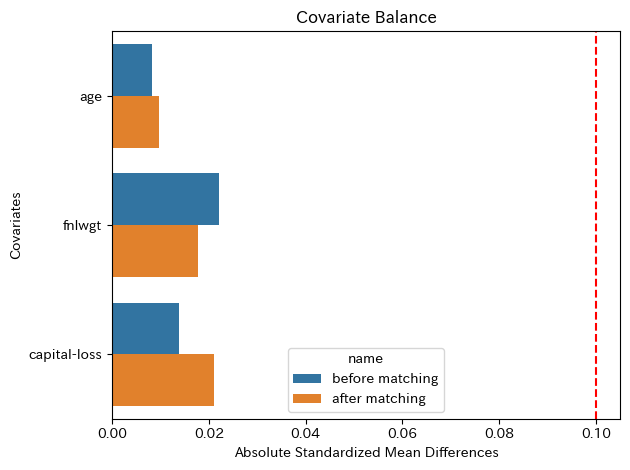

In [12]:
fig = love_plot(
    data=full_dataset, match_col='is_matched', treatment_col='is_test', 
    covariates=['age', 'fnlwgt', 'capital-loss'])